In [29]:
import pandas as pd
import numpy as np
from rdkit import Chem
import tmap as tm

### 1. Load dataset

In [30]:
url = "https://raw.githubusercontent.com/AnaChavezHdz/Art-Driven-by-Visual-Representations-of-Chemical-Space/main/Datasets/04_natural_remedies_16JUNE2023.csv"
DATA = pd.read_csv(url)
DATA.head(2)

,COMPOUND_ID,NAME_FOOD_DB,NEW_SMILES,FLAVOR_ID,NAME_FLAVOR,FLAVOR_GROUP
0,373,Prenyl acetate,CC(=O)OCC=C(C)C,44.0,sweet,balsamic
1,477,"1-(3,4-Dimethoxyphenyl)ethanone",COc1ccc(C(C)=O)cc1OC,44.0,sweet,balsamic


In [31]:
set(list(DATA["FLAVOR_GROUP"]))

{'balsamic', 'chemical', 'medicinal'}

### 2. Show overlapping compounds

Text(0.5, 0.98, 'COMPOUNDS')

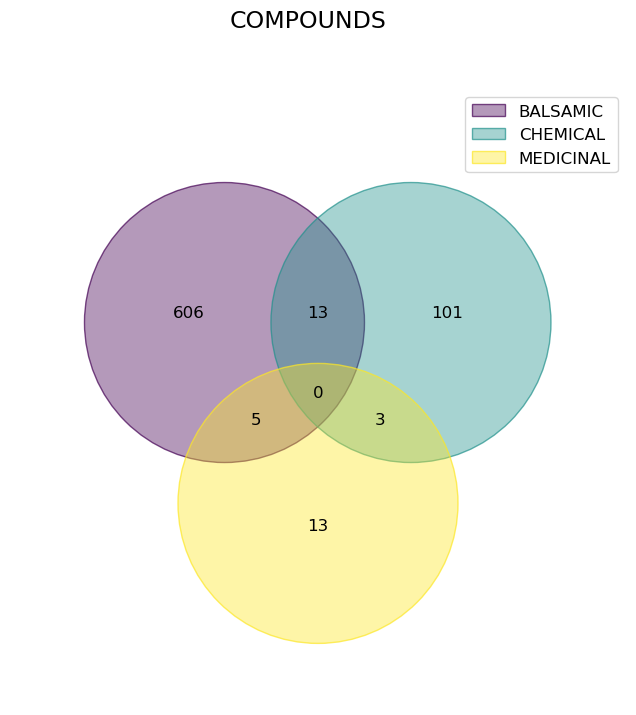

In [32]:
from venn import venn
import matplotlib.pyplot as plt
# Split dataset
BALSAMIC = DATA[DATA["FLAVOR_GROUP"]==str('balsamic')]
CHEMICAL = DATA[DATA["FLAVOR_GROUP"]==str('chemical')]
MEDICINAL = DATA[DATA["FLAVOR_GROUP"]==str('medicinal')]
# Generate venn diagram
COMPOUNDS = {"BALSAMIC":set(BALSAMIC["NEW_SMILES"]),
             "CHEMICAL":set(CHEMICAL["NEW_SMILES"]),
             "MEDICINAL":set(MEDICINAL["NEW_SMILES"])}
COMPOUNDS = venn(COMPOUNDS, fontsize=12)
plt.suptitle("COMPOUNDS", fontsize=17)

In [33]:
# Show initial labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'balsamic', 'medicinal', 'chemical'}


In [34]:
# Generate new labels of overlapping compounds
FinalSet = []
for name, group in DATA.groupby(["NEW_SMILES"]):
    label = list(group["FLAVOR_GROUP"])
    label.sort()
    FinalSet.append([name, "-".join(label)])

DATA = pd.DataFrame(FinalSet, columns=["NEW_SMILES", "FLAVOR_GROUP"])
print(DATA.shape)
DATA.head()

(741, 2)


/tmp/ipykernel_5422/3755106438.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in DATA.groupby(["NEW_SMILES"]):


,NEW_SMILES,FLAVOR_GROUP
0,C(=CC1OCCO1)c1ccccc1,balsamic
1,C1CCNCC1,balsamic
2,C1CSCCS1,chemical
3,C=C(C)C1CC=C(C)C(OC(=O)CC)C1,balsamic
4,C=C(C)C1CCC(C)C(OC(C)=O)C1,balsamic-medicinal


In [35]:
# new labels of overlapping compounds
print(set(list(DATA["FLAVOR_GROUP"])))

{'balsamic', 'medicinal', 'balsamic-medicinal', 'balsamic-chemical', 'chemical', 'chemical-medicinal'}


### 3. Calculate t-MAP

In [36]:
from rdkit.Chem import AllChem, MACCSkeys
from rdkit import Chem
import tmap as tm
#######################################################################################################
#MACCS keys
fps = [[int(y) for y in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()] for x in DATA["NEW_SMILES"]]
fps = [np.array(x) for x in fps]
##############################################################################################################
# Generate t-MAP
fps = [tm.VectorUchar(x) for x in fps]
enc = tm.Minhash(1024)
lf=tm.LSHForest(1024, 64, store=True) 
lf.batch_add(enc.batch_from_binary_array(fps))
lf.index()
cfg = tm.LayoutConfiguration()
cfg.node_size = 1/40 
cfg.k = 20 
cfg.kc = 10 
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

# Define coordinates
DATA["x"] = x
DATA["y"] = y

In [37]:
DATA.head()

,NEW_SMILES,FLAVOR_GROUP,x,y
0,C(=CC1OCCO1)c1ccccc1,balsamic,-0.425552,-0.030422
1,C1CCNCC1,balsamic,-0.121393,-0.443556
2,C1CSCCS1,chemical,-0.129438,-0.445346
3,C=C(C)C1CC=C(C)C(OC(=O)CC)C1,balsamic,-0.220361,-0.128991
4,C=C(C)C1CCC(C)C(OC(C)=O)C1,balsamic-medicinal,-0.204811,-0.135280


In [38]:
# Print new labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'balsamic', 'medicinal', 'balsamic-medicinal', 'balsamic-chemical', 'chemical', 'chemical-medicinal'}


In [39]:
def color(label):
    if label == 'balsamic':
        return int(1)
    elif label == 'chemical':
        return int(2)
    elif label == 'medicinal':
        return int(3)
    elif label == 'balsamic-chemical':
        return int(4)
    elif label == 'balsamic-medicinal':
        return int(5)
    elif label == 'chemical-medicinal':
        return int(6)

In [40]:
DATA["COLOR"] = [color(x) for x in DATA["FLAVOR_GROUP"]]

In [41]:
DATA.head(2)

,NEW_SMILES,FLAVOR_GROUP,x,y,COLOR
0,C(=CC1OCCO1)c1ccccc1,balsamic,-0.425552,-0.030422,1
1,C1CCNCC1,balsamic,-0.121393,-0.443556,1


### 4. Plot t-MAP

In [42]:
from faerun import Faerun
from matplotlib.colors import ListedColormap
# Relate index and new labels
legend_labels = [
(1,'balsamic'),
(2,'chemical'),
(3,'medicinal'),
(4,'balsamic-chemical'),
(5,'balsamic-medicinal'),
(6,'chemical-medicinal')
]

# Define color palette
custom_cmap = ListedColormap(['#3799ae','#4651a9', "#c94cd6", '#a394ca', 
                              '#a9ceea', '#bad2d7'])

faerun = Faerun(view="front", coords=False)

# Generate scatter plot
faerun = Faerun(view="front", coords=False)
faerun.add_scatter(
    "ESOL_Basic",
    {   "x": x, 
        "y": y,
        "c": list(DATA.COLOR.values),
        "labels": DATA["NEW_SMILES"]
    },
    point_scale=12,
    colormap=[custom_cmap],
    has_legend=True,
    legend_labels=legend_labels,
    legend_title = 'Data set',
)

# Plot t-MAP and save file.html
faerun.plot('Natural_remedies_TMAP_MACCSkeys', template="smiles", notebook_height=1000)

/home/ana/Documentos/DANIELA/Food DB/Natural_remedies_TMAP_MACCSkeys.html